# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

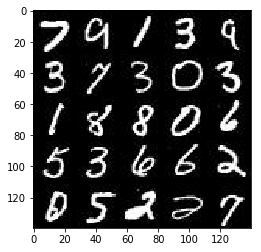

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

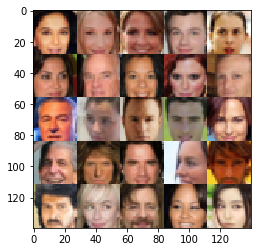

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,shape=(None,z_dim),name='inputs_z')
    learning_rate=tf.placeholder(tf.float32,name='learnrate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x1024 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=2, padding='same')
        #x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha* x2, x2)
        #print(x2.shape)
        # 4x4x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4,strides=1, padding='valid')
        #x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha* x3, x3)
        #print(x3.shape)
        # 7x7x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha* x4, x4)
        #print(x4.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 4, strides=2, padding='same')
        #print(logits.shape)
        # 32x32x3 now
        #logits=tf.resh
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [53]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim,True)
    d_model_real,d_logits_real=discriminator(input_real,False)
    d_model_fake,d_logits_fake=discriminator(g_model,reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
           
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,lr:learning_rate})
                #print('Hi')
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3534... Generator Loss: 0.0301
Epoch 1/2... Discriminator Loss: 3.9646... Generator Loss: 0.0705
Epoch 1/2... Discriminator Loss: 4.2662... Generator Loss: 0.2046
Epoch 1/2... Discriminator Loss: 2.8197... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 2.4310... Generator Loss: 0.3804
Epoch 1/2... Discriminator Loss: 1.9957... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.8892... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 1.9797... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 2.1327... Generator Loss: 0.5430
Epoch 1/2... Discriminator Loss: 1.7386... Generator Loss: 0.6057


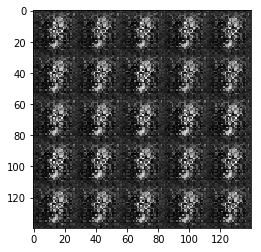

Epoch 1/2... Discriminator Loss: 1.6593... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.2096... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 1.0604


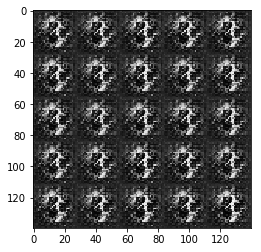

Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 1.1275
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.8487
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.6051
Epoch 1/2... Discriminator Loss: 1.5956... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.6801... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.7367
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.9191


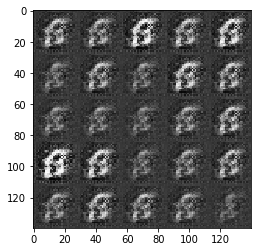

Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 1.7044... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.5224... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.8069


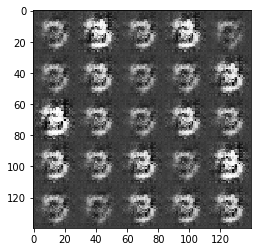

Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.9907
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.5242... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.6412
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.6611


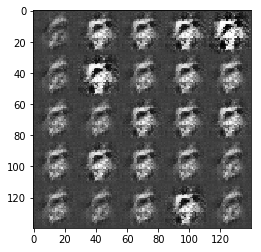

Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.6319... Generator Loss: 0.4532
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.8826


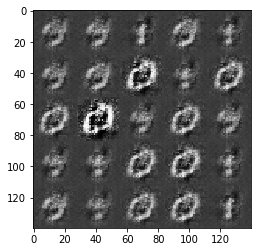

Epoch 2/2... Discriminator Loss: 1.1333... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.7728
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 1.7649
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 1.1909


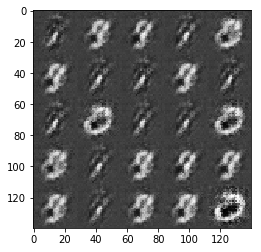

Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 1.2314
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 1.5578
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.7746
Epoch 2/2... Discriminator Loss: 1.5027... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 1.5293
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.3489


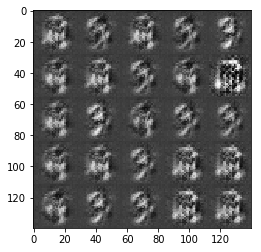

Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 1.6583
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 1.2825
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 1.4581
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 1.3269
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.4995
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 1.2557
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 1.0436
Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 1.6255


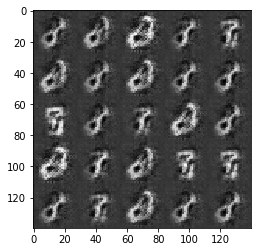

Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 1.2072
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 0.7508
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.8439


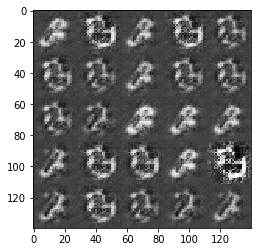

Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.5342
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.5985
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.5167
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 1.6050
Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 1.6619
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 1.3827


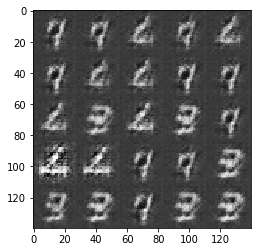

Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 1.5744
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 1.4798
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.4731
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 1.9627
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 1.4433
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 1.5967
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 1.4835
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.5792
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.6313


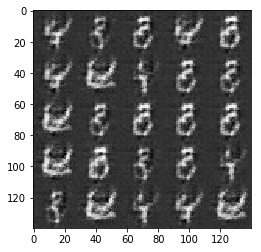

In [59]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.9240... Generator Loss: 6.8855
Epoch 1/1... Discriminator Loss: 1.8502... Generator Loss: 6.7814
Epoch 1/1... Discriminator Loss: 2.2405... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.8733... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.9144... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.6178


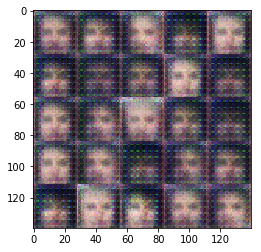

Epoch 1/1... Discriminator Loss: 1.7528... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.7738... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 2.6463... Generator Loss: 0.1306
Epoch 1/1... Discriminator Loss: 1.7658... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 1.9015... Generator Loss: 0.4500
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7258


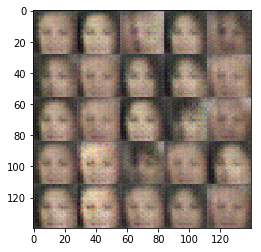

Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8935


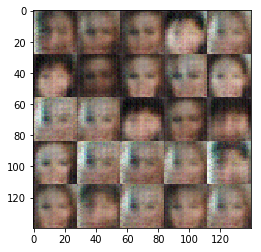

Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.9672


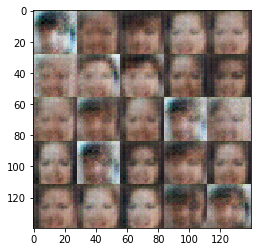

Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8325


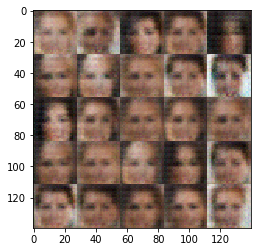

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7139


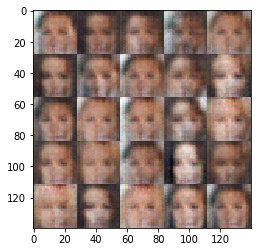

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6448


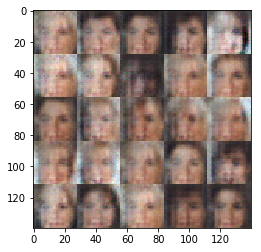

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.9635


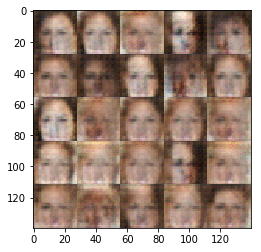

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.9218


In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.